Let's first get the imports out of the way.

In [0]:
import array
import gzip
import itertools
import numpy
import numpy.random as npr
import os
import struct
import time
from os import path
import urllib.request
import matplotlib.pyplot as plt

import jax.numpy as np
from jax.api import jit, grad
from jax.config import config
from jax.scipy.special import logsumexp
from jax import random

The following cell contains boilerplate code to download and load MNIST data.

In [5]:
_DATA = "/tmp/"

def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return numpy.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=numpy.float32):
  """Create a one-hot encoding of x of size k."""
  return numpy.array(x[:, None] == numpy.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return numpy.array(array.array("B", fh.read()), dtype=numpy.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return numpy.array(array.array("B", fh.read()),
                      dtype=numpy.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


#def mnist(create_outliers=False):
def mnist(create_outliers=True):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / numpy.float32(255.)
  test_images = _partial_flatten(test_images) / numpy.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if create_outliers:
    mum_outliers = 30000
    perm = numpy.random.RandomState(0).permutation(mum_outliers)
    train_images[:mum_outliers] = train_images[:mum_outliers][perm]

  return train_images, train_labels, test_images, test_labels

def shape_as_image(images, labels, dummy_dim=False):
  target_shape = (-1, 1, 28, 28, 1) if dummy_dim else (-1, 28, 28, 1)
  return np.reshape(images, target_shape), labels

#train_images, train_labels, test_images, test_labels = mnist(create_outliers=False)
train_images, train_labels, test_images, test_labels = mnist(create_outliers=True)
num_train = train_images.shape[0]

downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz to /tmp/


This function computes the output of a fully-connected neural network (i.e., multilayer perceptron) by iterating over all of its layers and:

1. taking the `activations` of the previous layer (or the input itself for the first hidden layer) to compute the `outputs` of a linear classifier. Recall the lectures: `outputs` is what we wrote $z=w\cdot x + b$ where $x$ is the input to the linear classifier. 
2. applying a non-linear activation. Here we will use $tanh$.

Complete the following cell to compute `outputs` and `activations`. 

In [0]:
def predict(params, inputs):
  activations = inputs
  for w, b in params[:-1]:
    outputs = np.dot(activations, w) + b 
    activations = np.tanh(outputs) 

  final_w, final_b = params[-1]
  logits = np.dot(activations, final_w) + final_b
  return logits - logsumexp(logits, axis=1, keepdims=True)

The following cell defines the accuracy of our model and how to initialize its parameters. 

In [0]:
def accuracy(params, batch):
  inputs, targets = batch
  target_class = np.argmax(targets, axis=1)
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == target_class)

def init_random_params(layer_sizes, rng=npr.RandomState(0)):
  scale = 0.1
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

The following cell creates a Python generator for our dataset. It outputs one batch of $n$ training examples at a time. 

In [0]:
batch_size = 32
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)
def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]
batches = data_stream()

Before we get started, we need to import two small libraries that contain boilerplate code for common neural network layer types and for optimizers like mini-batch SGD.

In [0]:
from jax.experimental import optimizers
from jax.experimental import stax

Here is a fully-connected neural network architecture, like the one of Problem 1, but this time defined with `stax`

In [0]:
init_random_params, predict = stax.serial(

    stax.Conv(32, (3, 3), strides=(1, 1)),
    stax.Relu,
    stax.MaxPool((2, 2), strides=(2, 2)),
   
    stax.Conv(64, (3, 3), strides=(1, 1)),
    stax.Relu,
    stax.Conv(64, (3, 3), strides=(1, 1)),
    stax.Relu,
    stax.MaxPool((2, 2), strides=(2, 2)),

    stax.Flatten,
    stax.Dense(100),
    stax.Relu,

    stax.Dense(10),
)

The following cell computes the loss of our model. Here we are using cross-entropy combined with a softmax but the implementation uses the `LogSumExp` trick for numerical stability. This is why our previous function `predict` returns the logits to which we substract the `logsumexp` of logits. We discussed this in class but you can read more about it [here](https://blog.feedly.com/tricks-of-the-trade-logsumexp/).

Complete the return line. Recall that the loss is defined as :
$$ l(X, Y) = -\frac{1}{n} \sum_{i\in 1..n}  \sum_{j\in 1.. K}y_j^{(i)} \log(f_j(x^{(i)})) = -\frac{1}{n} \sum_{i\in 1..n}  \sum_{j\in 1.. K}y_j^{(i)} \log\left(\frac{z_j^{(i)}}{\sum_{k\in 1..K}z_k^{(i)}}\right) $$
where $X$ is a matrix containing a batch of $n$ training inputs, and $Y$ a matrix containing a batch of one-hot encoded labels defined over $K$ labels. Here $z_j^{(i)}$ is the logits (i.e., input to the softmax) of the model on the example $i$ of our batch of training examples $X$.

In [0]:
def loss(params, batch):
  inputs, targets = batch
  logits = predict(params, inputs)
  preds  = stax.logsoftmax(logits)
  return -np.mean(np.sum(targets*preds, axis=1)) 

Next, we define the mini-batch SGD optimizer, this time with the optimizers library in JAX. 

In [0]:
learning_rate = 0.01
opt_init, opt_update, get_params = optimizers.momentum(learning_rate, 0.9)

@jit
def update(_, i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

The next cell contains our training loop, very similar to Problem 1. 

In [13]:
num_epochs = 10

key = random.PRNGKey(123)
_, init_params = init_random_params(key, (-1, 28, 28, 1))
opt_state = opt_init(init_params)
itercount = itertools.count()

for epoch in range(1, num_epochs + 1):
  for _ in range(num_batches):
    opt_state = update(key, next(itercount), opt_state, shape_as_image(*next(batches)))

  params = get_params(opt_state)
  test_acc = accuracy(params, shape_as_image(test_images, test_labels))
  test_loss = loss(params, shape_as_image(test_images, test_labels))
  print('Test set loss, accuracy (%): ({:.2f}, {:.2f})'.format(test_loss, 100 * test_acc))

Test set loss, accuracy (%): (0.83, 96.94)
Test set loss, accuracy (%): (0.68, 97.60)
Test set loss, accuracy (%): (0.84, 97.88)
Test set loss, accuracy (%): (0.76, 97.86)
Test set loss, accuracy (%): (0.66, 98.17)
Test set loss, accuracy (%): (0.76, 98.16)
Test set loss, accuracy (%): (0.79, 98.28)
Test set loss, accuracy (%): (0.67, 97.99)
Test set loss, accuracy (%): (0.57, 97.92)
Test set loss, accuracy (%): (0.69, 97.74)


# **Problem 1**


Visulize the MNIST test image "7"：

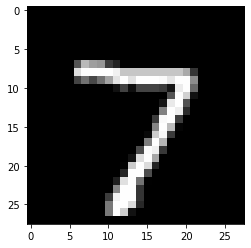

In [26]:
import matplotlib.pyplot as plt

seven_pic, seven_label = shape_as_image(test_images[0], test_labels[0])

seven_mnist = seven_pic.reshape([28, 28]);
plt.gray()
plt.imshow(seven_mnist)

Output the prediction result:

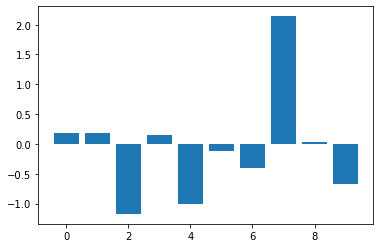

In [28]:
prediction = predict(params,seven_pic)                                           # "predict" function takes image (square matrix), output a column vector
plt.bar(np.arange(len(prediction[0])),prediction[0])
plt.show()

Perturb the image "7" and see prediction vector:

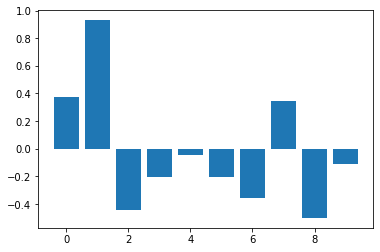

In [38]:
def perturb(image, label, epsilon):
  """
  image: after function "shape_as_image", intake one image, square matrix (1,28,28,1)
  label: after function "shape_as image", intake on one-hot column vector (10,)
  ind: return the max entry index from label (actual class)
  y: return the y (prediction) value that correspond to the labeled class
  t: one-hot value for the label
  epsilon: hyperparameter, tweak this until the wrong prediction is made
  delta: derivative of logistic cross-entropy loss, which is y-t
  per: perturbed data
  """
  ind = np.argmax(label)                                                       
  t = 1
  y = np.amax(prediction[ind])                                                    
  delta_L = y - t                                                                                                                                
  per = image + epsilon * np.sign(delta_L)                                      
  return np.array(per)

epsilon = 3
seven_per = perturb(seven_pic, seven_label, epsilon)
prediction_per = predict(params, seven_per)
plt.bar(np.arange(len(prediction_per[0])),prediction_per[0])
plt.show()                                                                      # for different network the prediction vector will be different

Let's see the wrong prediction and image:

7


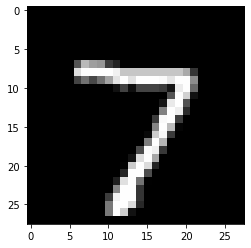

In [18]:
seven_per_pic = seven_per.reshape([28, 28]);
plt.gray()
plt.imshow(seven_per_pic)                                                       # cant really see the difference...

ind_per = np.argmax(prediction_per) 
print(ind_per)                                                                  # print out the perturbed sorted number

# **Problem 2**

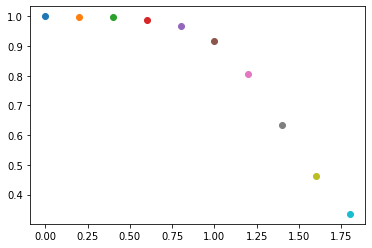

In [158]:
for epsilon in np.arange(0,2,0.2):
  count = 0
  acc_per = 0
  for i in range (0,len(test_images)):
    sample_img, sample_label = shape_as_image(test_images[i], test_labels[i]) 
    prediction_sample = predict(params,sample_img)
    if np.argmax(prediction_sample) == np.argmax(sample_label) and count <= 1000:  
      count = count + 1
      
      sample_per = perturb(sample_img, sample_label, epsilon)
      prediction_sample_per = predict(params, sample_per)

      acc_per = acc_per + accuracy(params, 
        shape_as_image(sample_per.reshape(1,784), sample_label.reshape(1,10)))  # when wrap the image and label back using "shape_as_image", they need to be reshaped to row vector
      
      acc_per_avg = acc_per/count

      #print (acc_per_avg)  
  plt.scatter(epsilon,acc_per_avg)  

# **Problem 3**

Modified perturbation function

In [0]:
def perturb_iteration(image, label, epsilon, iteration):
  """
  image: after function "shape_as_image", intake one image, square matrix (1,28,28,1)
  label: after function "shape_as image", intake on one-hot column vector (10,)
  iteration: how many iteration one wants
  epsilon: hyperparameter, tweak this until the wrong prediction is made
  per_prime: initial perturbed image
  per_iterative: iterative perturbed data
  """
  per_prime = perturb(image, label, epsilon)
  for k in range(0,iteration):
    per_iteration = perturb(per_prime,label,epsilon)
    per_prime = per_iteration

  return np.array(per_prime)

epsilon = 3
iteration = 5
seven_per_iteration = perturb_iteration(seven_pic, seven_label, epsilon/iteration, iteration)         

Iterative perturbing image "7" and see prediction vector

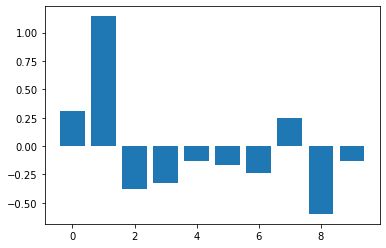

In [34]:
prediction_per_iteration = predict(params, seven_per_iteration)
plt.bar(np.arange(len(prediction_per_iteration[0])),prediction_per_iteration[0])
plt.show() 

See the iteratively perturbed image and predicted number:

1


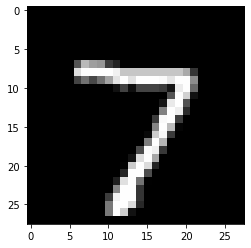

In [43]:
seven_per_iteration_pic = seven_per_iteration.reshape([28, 28]);
plt.gray()
plt.imshow(seven_per_iteration_pic)                                             # cant really see the difference...

ind_per_iteration = np.argmax(prediction_per_iteration) 
print(ind_per_iteration)    

# **Problem 4**

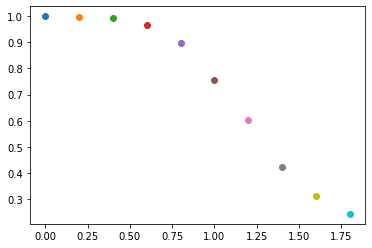

In [42]:
iteration = 5

for epsilon in np.arange(0,2,0.2):
  count = 0
  acc_per = 0
  for i in range (0,2000):
    sample_img, sample_label = shape_as_image(test_images[i], test_labels[i]) 
    prediction_sample = predict(params,sample_img)
    if np.argmax(prediction_sample) == np.argmax(sample_label) and count <= 1000:  
      count = count + 1
      
      sample_per = perturb_iteration(sample_img, sample_label, epsilon/iteration, iteration)
      prediction_sample_per = predict(params, sample_per)

      acc_per = acc_per + accuracy(params, 
        shape_as_image(sample_per.reshape(1,784), sample_label.reshape(1,10)))  # when wrap the image and label back using "shape_as_image", they need to be reshaped to row vector
      
      acc_per_avg = acc_per/count

      #print (acc_per_avg)  
  plt.scatter(epsilon,acc_per_avg) 